At first load the dataset using Pandas. We are not interested in the date, therefore, when we load the dataset we can exclude the first column.

Once loaded we can easily plot the whole dataset. The code to load and plot the dataset is listed below.

Can see an upward trend in the dataset over time.

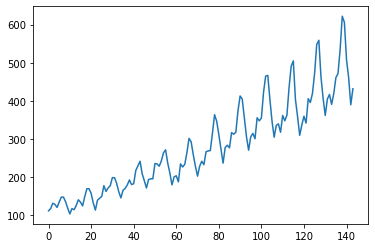

In [1]:
import pandas
import matplotlib.pyplot as plt
dataset = pandas.read_csv('airline-passengers.csv', usecols=[1], engine='python')
plt.plot(dataset)
plt.show()

Before we get started, import all of the functions and classes we intend to use.

In [2]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
numpy.random.seed(7)

Load the dataset again.

LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. So we have to rescale the data to the range of 0-to-1, also called normalizing.

In [4]:
dataframe = pandas.read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

We can easily normalize the dataset using the MinMaxScaler.

After we model our data and estimate the skill of our model on the training dataset, we need to get an idea of the skill of the model on new unseen data. For a normal classification or regression problem, we would do this using cross validation.

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

With time series data, the sequence of values is important. A simple method that we can use is to split the ordered dataset into train and test datasets.

In [6]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


Now we can define a function to create a new dataset, as described above.

The function takes two arguments: the dataset, which is a NumPy array that we want to convert into a dataset, and the look_back, which is the number of previous time steps to use as input variables to predict the next time period — in this case defaulted to 1.

This default will create a dataset where X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).

In [7]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

use this function to prepare the train and test datasets for modeling.

In [8]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].

We can transform the prepared train and test input data into the expected structure using reshape function.

In [9]:
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

We are now ready to design and fit our LSTM network for this problem.

The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.

In [10]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
94/94 - 1s - loss: 0.0367 - 1s/epoch - 12ms/step
Epoch 2/100
94/94 - 0s - loss: 0.0179 - 136ms/epoch - 1ms/step
Epoch 3/100
94/94 - 0s - loss: 0.0140 - 132ms/epoch - 1ms/step
Epoch 4/100
94/94 - 0s - loss: 0.0128 - 138ms/epoch - 1ms/step
Epoch 5/100
94/94 - 0s - loss: 0.0118 - 134ms/epoch - 1ms/step
Epoch 6/100
94/94 - 0s - loss: 0.0109 - 136ms/epoch - 1ms/step
Epoch 7/100
94/94 - 0s - loss: 0.0100 - 133ms/epoch - 1ms/step
Epoch 8/100
94/94 - 0s - loss: 0.0089 - 126ms/epoch - 1ms/step
Epoch 9/100
94/94 - 0s - loss: 0.0078 - 130ms/epoch - 1ms/step
Epoch 10/100
94/94 - 0s - loss: 0.0068 - 136ms/epoch - 1ms/step
Epoch 11/100
94/94 - 0s - loss: 0.0059 - 136ms/epoch - 1ms/step
Epoch 12/100
94/94 - 0s - loss: 0.0050 - 125ms/epoch - 1ms/step
Epoch 13/100
94/94 - 0s - loss: 0.0042 - 129ms/epoch - 1ms/step
Epoch 14/100
94/94 - 0s - loss: 0.0035 - 133ms/epoch - 1ms/step
Epoch 15/100
94/94 - 0s - loss: 0.0030 - 164ms/epoch - 2ms/step
Epoch 16/100
94/94 - 0s - loss: 0.0027 - 238ms/epoc

Once the model is fit, we can estimate the performance of the model on the train and test datasets. This will give us a point of comparison for new models.

In [11]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 22.72 RMSE
Test Score: 50.01 RMSE


Finally, we can generate predictions using the model for both the train and test dataset to get a visual indication of the skill of the model.

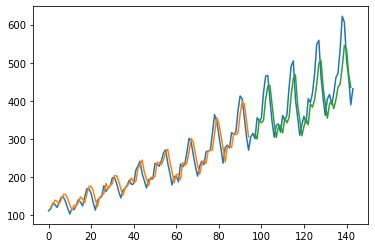

In [12]:
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()